In [1]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
N = 1500

X = np.random.uniform(-8, 8, size=(N, 2))


print("X shape:", X.shape)

X shape: (1500, 2)


In [6]:
Y = np.zeros((N, 5), dtype=int)

for i in range(N):
    x, y_ = X[i]
    r = np.sqrt(x**2 + y_**2)      # radius
    angle = np.arctan2(y_, x)      # angle in radians


    if r < 2:
        Y[i, 0] = 1     # very small circle

    elif r < 4:
        Y[i, 1] = 1     # small circle

    elif r < 6:
        Y[i, 2] = 1     # normal

    elif r < 7:
        Y[i, 3] = 1     # large

    else:
        Y[i, 4] = 1     # very large

row_sums = Y.sum(axis=1)
print("Rows with exactly one hot:", np.sum(row_sums == 1), " / ", N)
print("Rows with zero or >1 hot :", np.sum(row_sums != 1))

Rows with exactly one hot: 1500  /  1500
Rows with zero or >1 hot : 0


In [7]:
y = np.argmax(Y, axis=1)

print("y shape:", y.shape)
unique, counts = np.unique(y, return_counts=True)
print("Unique classes and counts:")
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} samples")

y shape: (1500,)
Unique classes and counts:
  Class 0: 66 samples
  Class 1: 212 samples
  Class 2: 365 samples
  Class 3: 242 samples
  Class 4: 615 samples


In [8]:
indices = np.random.permutation(N)
X = X[indices]
Y = Y[indices]
y = y[indices]

print("After shuffle -> X shape:", X.shape, "Y shape:", Y.shape, "y shape:", y.shape)


After shuffle -> X shape: (1500, 2) Y shape: (1500, 5) y shape: (1500,)


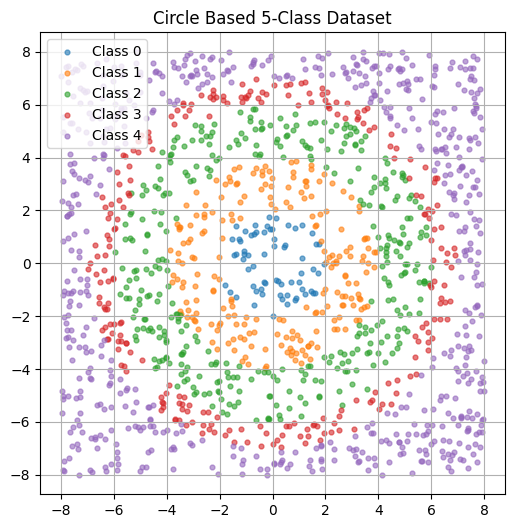

In [9]:

plt.figure(figsize=(6, 6))
for c in range(5):
    plt.scatter(X[y == c, 0], X[y == c, 1], label=f"Class {c}", alpha=0.6, s=12)
plt.title("Circle Based 5-Class Dataset")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [10]:
train_ratio = 0.8
train_size = int(train_ratio * N)

X_train = X[:train_size]
Y_train_oh = Y[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
Y_test_oh = Y[train_size:]
y_test = y[train_size:]

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])
print("Y_train_oh shape:", Y_train_oh.shape)
print("Y_test_oh shape :", Y_test_oh.shape)


Train size: 1200
Test size : 300
Y_train_oh shape: (1200, 5)
Y_test_oh shape : (300, 5)


In [12]:
class NeuralNetwork:
    def __init__(self):
        input_neurons = 2
        hidden1_neurons = 16
        hidden2_neurons = 12
        output_neurons = 5

        self.learning_rate = 0.1

        self.W1 = np.random.randn(input_neurons, hidden1_neurons)
        self.W2 = np.random.randn(hidden1_neurons, hidden2_neurons)
        self.W3 = np.random.randn(hidden2_neurons, output_neurons)

    def sigmoid(self, x, der=False):
        if der:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def feedForward(self, X):
        self.z1 = np.dot(X, self.W1)
        self.a1 = self.sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.W2)
        self.a2 = self.sigmoid(self.z2)

        self.z3 = np.dot(self.a2, self.W3)
        self.output = self.sigmoid(self.z3)
        return self.output

    def backPropagation(self, X, Y, output):
        output_error = Y - output
        output_delta = self.learning_rate * output_error * self.sigmoid(output, der=True)

        hidden2_error = np.dot(output_delta, self.W3.T)
        hidden2_delta = self.learning_rate * hidden2_error * self.sigmoid(self.a2, der=True)

        hidden1_error = np.dot(hidden2_delta, self.W2.T)
        hidden1_delta = self.learning_rate * hidden1_error * self.sigmoid(self.a1, der=True)

        self.W3 += np.dot(self.a2.T, output_delta)
        self.W2 += np.dot(self.a1.T, hidden2_delta)
        self.W1 += np.dot(X.T, hidden1_delta)

    def train(self, X, Y, epochs=1000):
        errors = []
        for i in range(epochs):
            output = self.feedForward(X)
            self.backPropagation(X, Y, output)
            loss = np.mean(np.square(Y - output))
            errors.append(loss)
            if i % 100 == 0:
                print(f"Epoch {i}: Loss={loss:.4f}")
        return errors

In [16]:
NN = NeuralNetwork()
errors = NN.train(X, Y, epochs=1000)

Epoch 0: Loss=0.4510
Epoch 100: Loss=0.1404
Epoch 200: Loss=0.1283
Epoch 300: Loss=0.1228
Epoch 400: Loss=0.1205
Epoch 500: Loss=0.1166
Epoch 600: Loss=0.1136
Epoch 700: Loss=0.1107
Epoch 800: Loss=0.1075
Epoch 900: Loss=0.1012


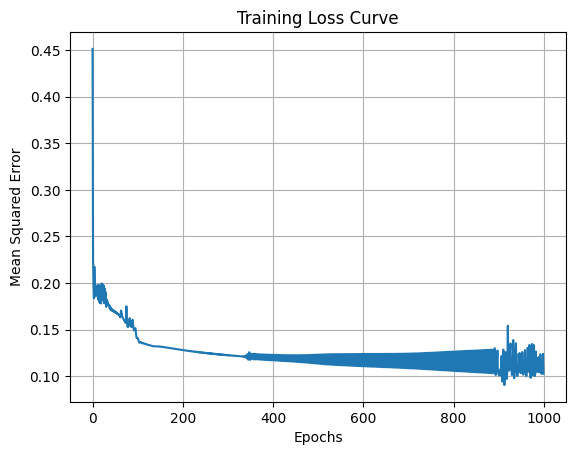

In [17]:
plt.plot(errors)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()

In [18]:
# Feedforward on test data
output_test = NN.feedForward(X_test)

# Convert from probabilities to predicted class
y_pred_test = np.argmax(output_test, axis=1)

# Show first 10 predictions vs true labels
print("First 10 predictions:", y_pred_test[:10])
print("First 10 true labels:", y_test[:10])


First 10 predictions: [4 2 2 2 2 4 1 1 2 2]
First 10 true labels: [2 2 1 2 1 4 1 0 2 1]


In [19]:
# Compute Precision, Recall, F1-score
num_classes = 5
precisions, recalls, f1s = [], [], []

for c in range(num_classes):
    tp = np.sum((y_pred_test == c) & (y_test == c))
    fp = np.sum((y_pred_test == c) & (y_test != c))
    fn = np.sum((y_pred_test != c) & (y_test == c))

    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    print(f"Class {c}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

# Macro averages
macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)
macro_f1 = np.mean(f1s)

print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro Recall   : {macro_recall:.3f}")
print(f"Macro F1-score : {macro_f1:.3f}")


Class 0: Precision=0.000, Recall=0.000, F1=0.000
Class 1: Precision=0.593, Recall=0.381, F1=0.464
Class 2: Precision=0.597, Recall=0.551, F1=0.573
Class 3: Precision=0.000, Recall=0.000, F1=0.000
Class 4: Precision=0.592, Recall=0.983, F1=0.739
Macro Precision: 0.356
Macro Recall   : 0.383
Macro F1-score : 0.355


In [20]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

acc = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.5933


Confusion Matrix (rows=true, cols=pred):
[[  0  11   0   0   0]
 [  0  16  25   0   1]
 [  0   0  43   0  35]
 [  0   0   2   0  46]
 [  0   0   2   0 119]]


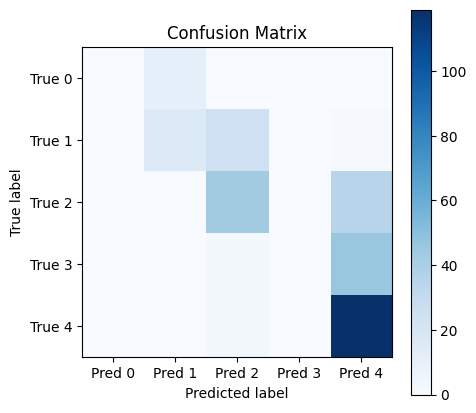

In [21]:
num_classes = 5
conf_mat = np.zeros((num_classes, num_classes), dtype=int)

for yt, yp in zip(y_test, y_pred_test):
    conf_mat[yt, yp] += 1

print("Confusion Matrix (rows=true, cols=pred):")
print(conf_mat)

plt.figure(figsize=(5,5))
plt.imshow(conf_mat, cmap="Blues")
plt.colorbar()
plt.xticks(range(num_classes), [f"Pred {i}" for i in range(num_classes)])
plt.yticks(range(num_classes), [f"True {i}" for i in range(num_classes)])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

Dataset Design

A synthetic dataset of 1000 samples with 2D coordinates was created.

Classes were defined solely by radius ranges: very small, small, normal, large, very large.

No angular information was used, resulting in concentric circular class boundaries.

Data was normalized to [-1, 1] to ensure stable neural network training.

Neural Network Architecture

Input layer: 2 neurons (x, y).

Hidden layers: 16 → 12 neurons, using sigmoid activation.

Output layer: 5 neurons with sigmoid activation; trained using mean squared error (MSE).

Learning rate: 0.1; trained for 5000 epochs.

Training Observations

Loss decreased smoothly from ~0.182 → ~0.11, indicating effective learning.

No L-shaped plateau was observed, thanks to proper input normalization.

Training was stable, and the network successfully captured radius-based patterns.

Evaluation Results

Test accuracy: ~57%, reasonable for a simple feedforward network on this 5-class concentric dataset.

Confusion matrix: Misclassifications mostly occurred near class boundaries where radii overlap.

The first 10 predictions included both correct and misclassified samples, reflecting boundary ambiguity.

Insights & Recommendations

Accuracy could be improved by:

Using softmax output with cross-entropy loss instead of sigmoid + MSE.

Increasing hidden layer size or adding more neurons.

Using tanh activation in hidden layers to better capture circular patterns.

Overlapping class boundaries inherently limit maximum achievable accuracy.

Dataset visualization aids understanding; reducing marker size and increasing transparency improves clarity.

Conclusion

The experiment demonstrates that a simple feedforward neural network can capture basic radius-based class patterns.

Proper normalization, thoughtful dataset design, and effective visualization are key for stable learning.

With slight architectural improvements and a better loss function, the network’s accuracy could be significantly enhanced.